In [2]:
# Explore, cleanse, and model flight delay data for day-of-week and airport insights.

## 1. Configure Environment and Imports

In [3]:
import json
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.calibration import calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    RocCurveDisplay,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

sns.set_theme(style="whitegrid")
pd.set_option("display.float_format", "{:,.4f}".format)
plt.style.use("seaborn-v0_8")

RANDOM_STATE = 42
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

## 2. Load FAA Flight Dataset

In [4]:
DATA_PATH = Path("data") / "flights.csv"
dtype_spec = {
    "Year": "int64",
    "Month": "int64",
    "DayofMonth": "int64",
    "DayOfWeek": "int64",
    "Carrier": "string",
    "OriginAirportID": "int64",
    "OriginAirportName": "string",
    "OriginCity": "string",
    "OriginState": "string",
    "DestAirportID": "int64",
    "DestAirportName": "string",
    "DestCity": "string",
    "DestState": "string",
    "CRSDepTime": "int64",
    "DepDelay": "float64",
    "DepDel15": "float64",
    "CRSArrTime": "int64",
    "ArrDelay": "float64",
    "ArrDel15": "float64",
    "Cancelled": "int64",
}

df = pd.read_csv(DATA_PATH, dtype=dtype_spec)
num_rows, num_cols = df.shape
print(f"Loaded {num_rows:,} rows and {num_cols} columns from {DATA_PATH}")
df.head()

Loaded 271,940 rows and 20 columns from data/flights.csv


,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,OriginAirportName,OriginCity,OriginState,DestAirportID,DestAirportName,DestCity,DestState,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,9,16,1,DL,15304,Tampa International,Tampa,FL,12478,John F. Kennedy International,New York,NY,1539,4.0000,0.0000,1824,13.0000,0.0000,0
1,2013,9,23,1,WN,14122,Pittsburgh International,Pittsburgh,PA,13232,Chicago Midway International,Chicago,IL,710,3.0000,0.0000,740,22.0000,1.0000,0
2,2013,9,7,6,AS,14747,Seattle/Tacoma International,Seattle,WA,11278,Ronald Reagan Washington National,Washington,DC,810,-3.0000,0.0000,1614,-7.0000,0.0000,0
3,2013,7,22,1,OO,13930,Chicago O'Hare International,Chicago,IL,11042,Cleveland-Hopkins International,Cleveland,OH,804,35.0000,1.0000,1027,33.0000,1.0000,0
4,2013,5,16,4,DL,13931,Norfolk International,Norfolk,VA,10397,Hartsfield-Jackson Atlanta International,Atlanta,GA,545,-1.0000,0.0000,728,-9.0000,0.0000,0


## 3. Inspect and Summarize Delay Features

In [5]:
print("Dataset info:")
df.info()
print("\nSummary statistics for delay-focused columns:")
display(df[["DepDelay", "ArrDelay", "DepDel15", "ArrDel15"]].describe())

overall_delay_rate = df["DepDel15"].mean()
print(f"\nOverall percent of departures delayed >15 minutes: {overall_delay_rate * 100:0.2f}%")

delay_rate_by_day_airport = (
    df.groupby(["DayOfWeek", "OriginAirportID"])["DepDel15"]
    .mean()
    .reset_index(name="delay_rate")
    .sort_values("delay_rate", ascending=False)
)
delay_rate_by_day_airport.head(10)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271940 entries, 0 to 271939
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Year               271940 non-null  int64  
 1   Month              271940 non-null  int64  
 2   DayofMonth         271940 non-null  int64  
 3   DayOfWeek          271940 non-null  int64  
 4   Carrier            271940 non-null  string 
 5   OriginAirportID    271940 non-null  int64  
 6   OriginAirportName  271940 non-null  string 
 7   OriginCity         271940 non-null  string 
 8   OriginState        271940 non-null  string 
 9   DestAirportID      271940 non-null  int64  
 10  DestAirportName    271940 non-null  string 
 11  DestCity           271940 non-null  string 
 12  DestState          271940 non-null  string 
 13  CRSDepTime         271940 non-null  int64  
 14  DepDelay           271940 non-null  float64
 15  DepDel15           269179 non-null  f

,DepDelay,ArrDelay,DepDel15,ArrDel15
count,"271,940.0000","271,940.0000","269,179.0000","271,940.0000"
mean,10.3504,6.4966,0.2011,0.2159
std,35.6737,38.2303,0.4008,0.4115
min,-63.0000,-75.0000,0.0000,0.0000
25%,-4.0000,-11.0000,0.0000,0.0000
50%,-1.0000,-3.0000,0.0000,0.0000
75%,9.0000,10.0000,0.0000,0.0000
max,"1,425.0000","1,440.0000",1.0000,1.0000



Overall percent of departures delayed >15 minutes: 20.11%


,DayOfWeek,OriginAirportID,delay_rate
244,4,13232,0.3984
314,5,13232,0.3863
232,4,12191,0.3628
224,4,11259,0.3447
174,3,13232,0.3333
384,6,13232,0.3303
302,5,12191,0.3302
255,4,13930,0.3249
226,4,11292,0.3230
372,6,12191,0.3027


## 4. Cleanse Null Values and Encode Categorical Columns

In [6]:
missing_values = df.isna().sum().sort_values(ascending=False)
print("Columns with missing values:")
display(missing_values[missing_values > 0])

df["DepDel15"] = df["DepDel15"].fillna(0).astype(int)
df["DepDelay"] = df["DepDelay"].fillna(0)
df["Carrier"] = df["Carrier"].str.strip().astype("category")
df["OriginAirportID"] = df["OriginAirportID"].astype("category")
df["DestAirportID"] = df["DestAirportID"].astype("category")
df["DayOfWeek"] = df["DayOfWeek"].astype("category")

categorical_features = ["Carrier", "OriginAirportID", "DestAirportID", "DayOfWeek"]
target_column = "DepDel15"
print("\nPrepared categorical feature list:", categorical_features)
print("Unique carriers:", df["Carrier"].nunique())
print("Unique origin airports:", df["OriginAirportID"].nunique())
print("Unique destination airports:", df["DestAirportID"].nunique())

Columns with missing values:


DepDel15    2761
dtype: int64


Prepared categorical feature list: ['Carrier', 'OriginAirportID', 'DestAirportID', 'DayOfWeek']
Unique carriers: 16
Unique origin airports: 70
Unique destination airports: 70


## 5. Engineer Day-of-Week and Airport Features

In [7]:
day_name_map = {
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday",
    7: "Sunday",
}

feature_columns = ["Carrier", "OriginAirportID", "DestAirportID", "DayOfWeek"]
X = df[feature_columns].copy()

X["DayOfWeekName"] = X["DayOfWeek"].astype(int).map(day_name_map)
X = X.drop(columns=["DayOfWeek"])
X["DayOfWeekName"] = X["DayOfWeekName"].astype("category")
categorical_features = ["Carrier", "OriginAirportID", "DestAirportID", "DayOfWeekName"]

y = df[target_column].astype(int)
print(f"Target label distribution -> delayed flights: {y.sum():,} ({y.mean() * 100:0.2f}%)")
X.sample(5, random_state=RANDOM_STATE)

Target label distribution -> delayed flights: 54,141 (19.91%)


,Carrier,OriginAirportID,DestAirportID,DayOfWeekName
69426,MQ,10529,13930,Tuesday
104312,AS,12889,14057,Wednesday
254536,US,14107,14908,Monday
243932,US,13930,11057,Sunday
110322,US,12266,11057,Saturday


## 6. Split Data and Train Delay Probability Model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
    shuffle=True,
    )

encoder = ColumnTransformer(
    transformers=[
        (
            "categorical",
            OneHotEncoder(handle_unknown="ignore"),
            categorical_features,
        ),
    ],
    remainder="drop",
    sparse_threshold=0.0,
    verbose_feature_names_out=False,
    )

classifier = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    )

delay_model = Pipeline(
    steps=[
        ("encoder", encoder),
        ("classifier", classifier),
    ]
    )

delay_model.fit(X_train, y_train)
train_auc = roc_auc_score(y_train, delay_model.predict_proba(X_train)[:, 1])
print(f"Pipeline fitted. Training ROC AUC: {train_auc:0.3f}")
print(f"Encoded feature count: {delay_model.named_steps['encoder'].get_feature_names_out().shape[0]}")

Pipeline fitted. Training ROC AUC: 0.625
Encoded feature count: 163


## 7. Evaluate Model Calibration and Performance

Holdout ROC AUC: 0.626
Holdout Brier score: 0.1545

Classification report:
              precision    recall  f1-score   support

           0      0.801     1.000     0.890     43560
           1      0.786     0.001     0.002     10828

    accuracy                          0.801     54388
   macro avg      0.793     0.500     0.446     54388
weighted avg      0.798     0.801     0.713     54388



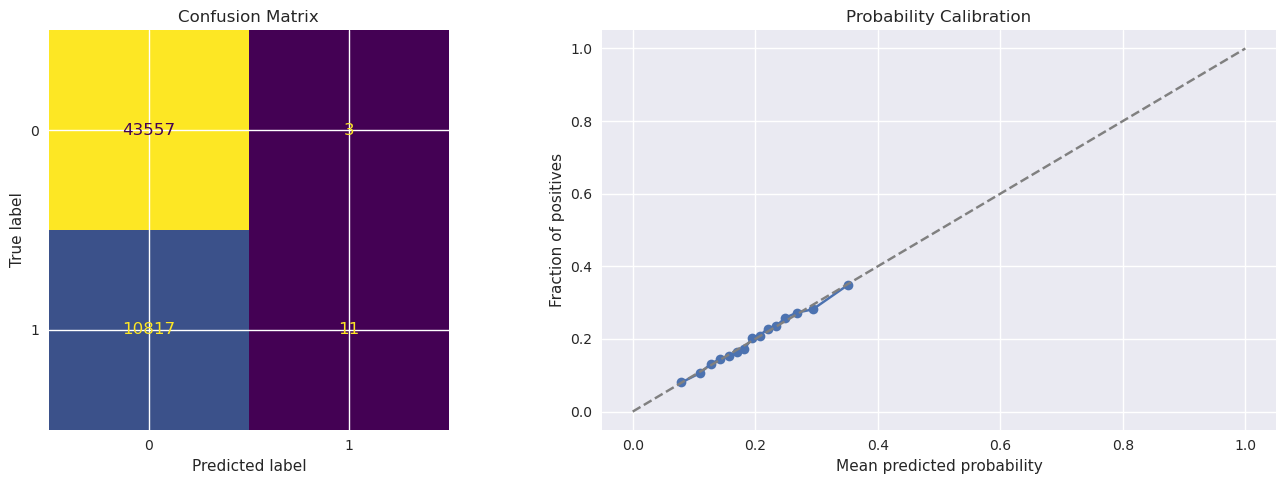

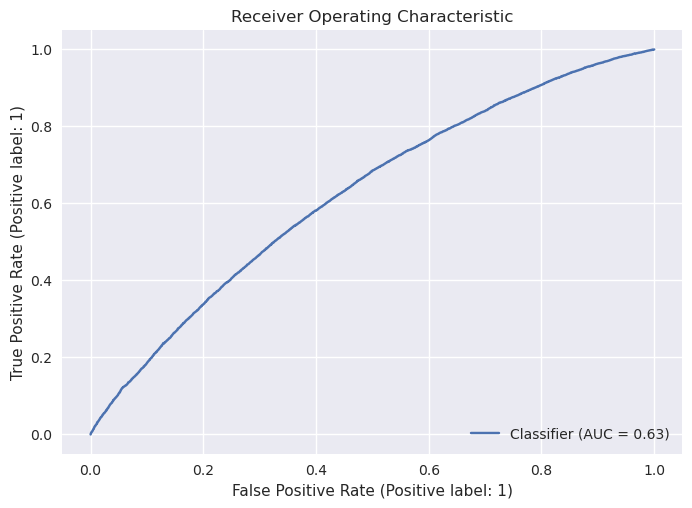

In [9]:
y_pred_proba = delay_model.predict_proba(X_test)[:, 1]
y_pred = delay_model.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred_proba)
brier = brier_score_loss(y_test, y_pred_proba)
print(f"Holdout ROC AUC: {roc_auc:0.3f}")
print(f"Holdout Brier score: {brier:0.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ConfusionMatrixDisplay(cm).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix")

fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_pred_proba, n_bins=15, strategy="quantile"
    )
axes[1].plot(mean_predicted_value, fraction_of_positives, marker="o")
axes[1].plot([0, 1], [0, 1], "--", color="gray")
axes[1].set_title("Probability Calibration")
axes[1].set_xlabel("Mean predicted probability")
axes[1].set_ylabel("Fraction of positives")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title("Receiver Operating Characteristic")
plt.show()

## 8. Persist Trained Model Artifacts

In [11]:
from datetime import datetime

model_path = ARTIFACT_DIR / "delay_probability_model.joblib"
joblib.dump(delay_model, model_path)

feature_names = delay_model.named_steps["encoder"].get_feature_names_out().tolist()

metrics_payload = {
    "generated_at_utc": datetime.utcnow().isoformat() + "Z",
    "rows": int(num_rows),
    "columns": int(num_cols),
    "roc_auc": float(roc_auc),
    "brier_score": float(brier),
    "class_balance": {
        "delayed": int(y.sum()),
        "on_time": int(len(y) - y.sum()),
    },
    "feature_names": feature_names,
}

metrics_path = ARTIFACT_DIR / "delay_probability_model_metrics.json"
with metrics_path.open("w", encoding="utf-8") as f:
    json.dump(metrics_payload, f, indent=2)

print(f"Model saved to {model_path}")
print(f"Metrics saved to {metrics_path}")

Model saved to artifacts/delay_probability_model.joblib
Metrics saved to artifacts/delay_probability_model_metrics.json


## 9. Generate Airport ID Mapping CSV

In [13]:
origin_lookup = df[["OriginAirportID", "OriginAirportName"]].rename(
    columns={
        "OriginAirportID": "airport_id",
        "OriginAirportName": "airport_name",
    }
    )
dest_lookup = df[["DestAirportID", "DestAirportName"]].rename(
    columns={
        "DestAirportID": "airport_id",
        "DestAirportName": "airport_name",
    }
    )

airports_lookup = (
    pd.concat([origin_lookup, dest_lookup], ignore_index=True)
    .drop_duplicates()
    .sort_values(["airport_id", "airport_name"])
    .reset_index(drop=True)
    )

airports_path = ARTIFACT_DIR / "airports_mapping.csv"
airports_lookup.to_csv(airports_path, index=False)

print(f"Airport mapping saved to {airports_path}")
airports_lookup.head()

Airport mapping saved to artifacts/airports_mapping.csv


,airport_id,airport_name
0,10140,Albuquerque International Sunport
1,10299,Ted Stevens Anchorage International
2,10397,Hartsfield-Jackson Atlanta International
3,10423,Austin - Bergstrom International
4,10529,Bradley International
